In [1]:
# https://www.interviewqs.com/blog/py-stock-correlation

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from datetime import datetime, timedelta
import time
import pandas as pd
from matplotlib import pyplot as plt  # Importing the pyplot module
import numpy as np 
import seaborn as sns

# Conversion
rate = 1.47

stocks = ["AI.PA","TTE", "MC.PA"] # "XOP", "TTE", "SHEL"]  # Add more stocks as needed, "AI.PA", "IYM" , "XOP",  "SHEL", "XOP", , "SHEL", "IYM", "BP"

range = 365
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=range)).strftime('%Y-%m-%d')

url_base = 'https://finance.yahoo.com/quote/'

# Initialize lists to store data
all_data = []

# Initialize Selenium webdriver
driver = webdriver.Chrome()  # You need to have Chrome webdriver installed. You can use other webdrivers too.

# Loop through the stocks
for stock in stocks:
    url = url_base + stock + '/history'
    driver.get(url)
    time.sleep(2)  # Allow time for the page to load

    # Find and click the 'Accept all' button if it exists
    try:
        accept_button = driver.find_element(By.XPATH, '//*[@id="consent-page"]/div/div/div/form/div[2]/div[2]/button[1]')
        accept_button.click()
        time.sleep(2)  # Allow time for the page to load after accepting cookies
    except NoSuchElementException:
        pass

    driver.execute_script("window.scrollTo(0, document.body.scrollHeight*100);")
    time.sleep(2)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight*100);")

    time.sleep(2)  # Wait for the page to load after scrolling
    
    # Locate the historical data table
    table = driver.find_element(By.XPATH, '//*[@id="Col1-1-HistoricalDataTable-Proxy"]/section/div[2]/table')

    # Extract data from each row of the table
    rows = table.find_elements(By.TAG_NAME, 'tr')
    stock_data = []
    for row in rows[1:]:  # Skip the header row
        columns = row.find_elements(By.TAG_NAME, 'td')
        row_data = [column.text for column in columns]
        try:
            if datetime.strptime(row_data[0], '%b %d, %Y') >= datetime.strptime(start_date, '%Y-%m-%d'):
                stock_data.append(row_data)
        except ValueError:
            pass
    
    all_data.append(pd.DataFrame(stock_data, columns=['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']))

# Close the webdriver
driver.quit()

# Process data into Pandas DataFrame
for idx, df in enumerate(all_data):
    df['Stock'] = stocks[idx]

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(all_data, ignore_index=True)


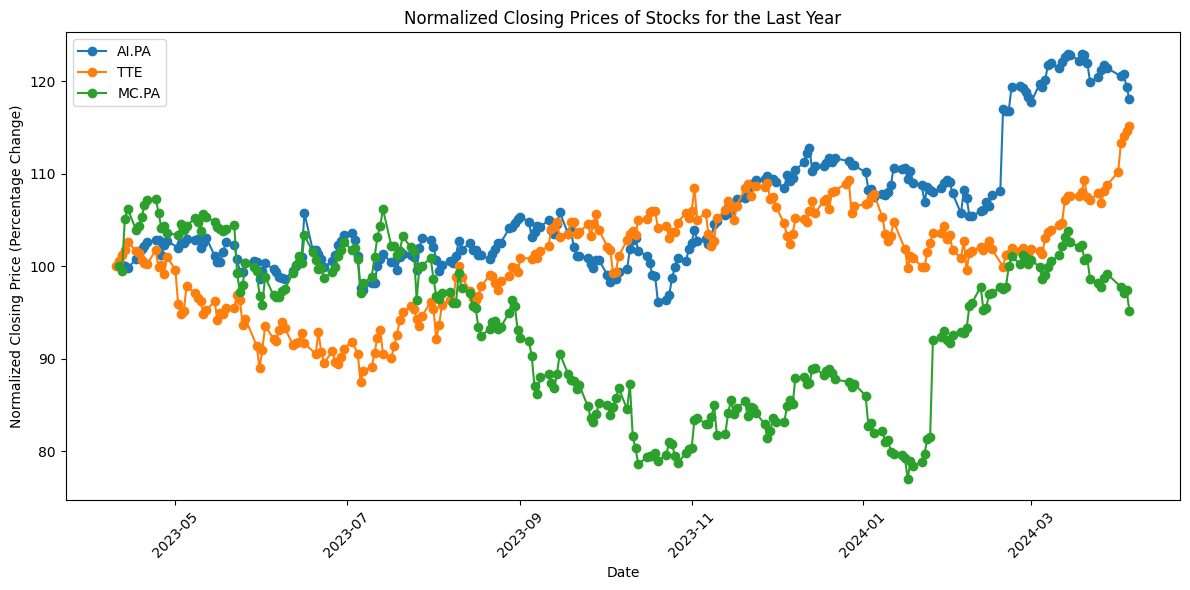

In [2]:
# Convert relevant columns to numeric if necessary
numeric_cols = ['Open', 'High', 'Low', 'Close*', 'Adj Close**']
final_df[numeric_cols] = final_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Conditionally multiply columns by the rate for stock "AI.PA"
final_df.loc[final_df['Stock'] == 'AI.PA', numeric_cols] *= rate
final_df.loc[final_df['Stock'] == 'MC.PA', numeric_cols] *= rate

df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
final_df['Date'] = pd.to_datetime(final_df['Date'], format='%b %d, %Y')
final_df.sort_values(by=['Date'], inplace=True)

plt.figure(figsize=(12, 6))

for stock in stocks:
    stock_df = final_df[final_df['Stock'] == stock].dropna()  # Filter DataFrame for each stock and drop rows with missing values
    stock_df['Close*'] = pd.to_numeric(stock_df['Close*'], errors='coerce')  # Convert 'Close*' column to numeric, coercing errors to NaN
    initial_price = stock_df.iloc[0]['Close*']  # Get the initial closing price of the stock
    normalized_prices = (stock_df['Close*'] / initial_price) * 100  # Normalize closing prices as percentage change from initial price
    plt.plot(stock_df['Date'], normalized_prices, marker='o', linestyle='-', label=stock)

plt.title('Normalized Closing Prices of Stocks for the Last Year')
plt.xlabel('Date')
plt.ylabel('Normalized Closing Price (Percentage Change)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Assuming df is your DataFrame containing the data
# Pivot the DataFrame to create a new DataFrame with one row per date and columns for each stock
pivot_df = final_df.pivot_table(index='Date', columns='Stock', values='Close*').reset_index()

# Optionally, rename the columns to match the format you specified
pivot_df.columns.name = None  # Remove the name of the columns index
pivot_df = pivot_df.dropna()

corr_df = pivot_df.corr(method='pearson')
#reset symbol as index (rather than 0-X)
corr_df.head().reset_index()
#del corr_df.index.name
corr_df.head(10)

/var/folders/1p/cr0lvl710vn22z5gtz3rhpdr0000gn/T/ipykernel_42246/1587659382.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = pivot_df.corr(method='pearson')


,AI.PA,MC.PA,TTE
AI.PA,1.000000,0.057691,0.583077
MC.PA,0.057691,1.000000,-0.522516
TTE,0.583077,-0.522516,1.000000


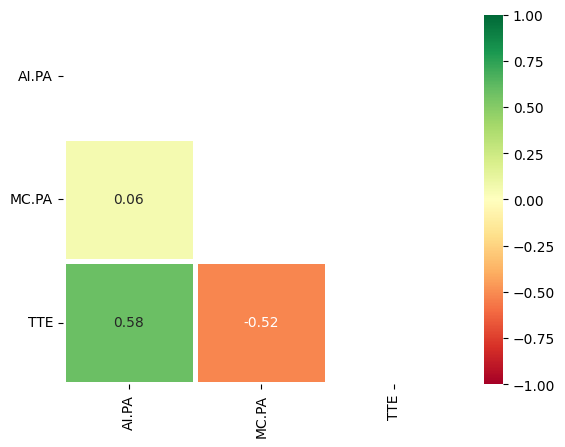

In [4]:
import seaborn as sns
# Create a mask to hide the upper triangle (since it repeats itself)
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

# Generate plot with labels
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0, mask=mask, linewidths=2.5, annot=True, fmt=".2f")
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()